# Grover's algorithm

## Table of Contents

- [Introduction](#introduction)
- [Unstructured search](#unstructured-search)
    - [Summary](#summary)
    - [Formal problem statement](#formal-problem-statement)
- [Grover's algorithm](#grovers-algorithm)
    - [Phase query gates](#phase-query-gates)
    - [Description of the algorithm](#description-of-the-algorithm)
    - [Application to Search](#application-to-search)
- [Analysis](#analysis)
    - [Solutions and non-solutions](#solutions-and-non-solutions)
    - [An observation about the Grover operation](#observation-grover)
    - [Action of the Grover operation](#action-grover)
    - [Geometric picture](#geometric-picture)
- [Choosing the number of iterations](#choosing-iterations)
    - [Unique search](#unique-search)
    - [Multiple solutions](#multiple-solutions)
    - [Unknown number of solutions](#unknown-solutions)
    - [The trivial cases](#trivial-cases)
- [Qiskit implementation](#qiskit-implementation)
- [Concluding remarks](#concluding-remarks)


## [Introduction](#introduction)
This lesson is on Grover's algorithm, which is a quantum algorithm for so-called unstructured search problems that offers a quadratic improvement over classical algorithms. What this means is that Grover's algorithm requires a number of operations on the order of the square-root of the number of operations required to solve unstructured search classically — which is equivalent to saying that classical algorithms for unstructured search must have a cost at least on the order of the square of the cost of Grover's algorithm. Grover's algorithm, together with its extensions and underlying methodology, turn out to be broadly applicable, leading to a quadratic advantage for many interesting computational tasks that may not initially look like unstructured search problems on the surface.

While the broad applicability of Grover's searching technique is compelling, it should be acknowledged here at the start of the lesson that the quadratic advantage it offers seems unlikely to lead to a practical advantage of quantum over classical computing any time soon. Classical computing hardware is currently so much more advanced than quantum computing hardware that the quadratic quantum-over-classical advantage offered by Grover's algorithm is certain to be washed away by the staggering clock speeds of modern classical computers for any unstructured search problem that could feasibly be run on the quantum computers of today.

As quantum computing technology advances, however, Grover's algorithm may have potential. Indeed, some of the most important and impactful classical algorithms ever discovered, including the fast Fourier transform and fast sorting (e.g., quicksort and mergesort), offer slightly less than a quadratic advantage over naive approaches to the problems they solve. The key difference here, of course, is that an entirely new technology (meaning quantum computing) is required to run Grover's algorithm. While this technology is still very much in its infancy in comparison to classical computing, we should not be so quick to underestimate the potential of technological advances that could allow a quadratic advantage of quantum over classical computing to one day offer tangible practical benefits.

## [Unstructured search](#unstructured-search)


### [Summary](#summary)

We'll begin with a description of the problem that Grover's algorithm solves. As usual, we'll let Σ = {0, 1} denote the binary alphabet throughout this discussion.

Suppose that:

$$
f : \Sigma^n \to \Sigma
$$

is a function from binary strings of length $ n $ to bits. We'll assume that we can compute this function efficiently, but otherwise it's arbitrary and we can't rely on it having a special structure or specific implementation that suits our needs.

What Grover's algorithm does is to search for a string $ x \in \Sigma^n $ for which $ f(x) = 1 $. We'll refer to strings like this as **solutions** to the searching problem. If there are multiple solutions, then any one of them is considered to be a correct output, and if there are no solutions, then a correct answer requires that we report that there are no solutions.

This task is described as an **unstructured search** problem because we can't rely on $ f $ having any particular structure to make it easy. We're not searching an ordered list, or within some data structure specifically designed to facilitate searching—we're essentially looking for a needle in a haystack.

One way to perform this searching task classically is to simply iterate through all of the strings $ x \in \Sigma^n $, evaluating $ f $ on each one to check whether or not it is a solution.

Hereafter, let's write:

$$
N = 2^n
$$

for the sake of convenience. There are $ N $ strings in $ \Sigma^n $, so iterating through all of them requires $ N $ evaluations of $ f $. Operating under the assumption that we're limited to evaluating $ f $ on chosen inputs, this is the best we can do with a deterministic algorithm if we want to guarantee success. With a probabilistic algorithm, we might hope to save time by randomly choosing input strings to $ f $, but we'll still require $ O(N) $ evaluations of $ f $ if we want this method to succeed with high probability.

Grover's algorithm solves this search problem with high probability with just $ O(\sqrt{N}) $ evaluations of $ f $. To be clear, these function evaluations must happen in **superposition**, similar to the query algorithms discussed in the *Quantum query algorithms* lesson, including Deutsch's algorithm, the Deutsch-Jozsa algorithm, and Simon's algorithm. Unlike those algorithms, Grover's algorithm takes an **iterative approach**: it evaluates $ f $ on superpositions of input strings and intersperses these evaluations with other operations that have the effect of creating interference patterns, leading to a solution with high probability (if one exists) after $ O(\sqrt{N}) $ iterations.


### [Formal problem statement](#formal-problem-statement)

We'll formalize the problem that Grover's algorithm solves using the **query model** of computation. That is, we'll assume that we have access to the function $ f : \Sigma^n \rightarrow \Sigma $ through a query gate defined in the usual way:

$$
U_f(|a\rangle|x\rangle) = |a \oplus f(x)\rangle|x\rangle
$$

for every $ x \in \Sigma^n $ and $ a \in \Sigma $. This is the action of $ U_f $ on standard basis states, and its action in general is determined by linearity.

As was discussed in the Quantum algorithmic foundations lesson, if we have a Boolean circuit for computing $ f $, we can transform that Boolean circuit description into a quantum circuit implementing $ U_f $ (using some number of workspace qubits that start and end the computation in the $ |0\rangle $ state). So, although we're using the query model to formalize the problem that Grover's algorithm solves, it is not limited to this model; we can run Grover's algorithm on any function $ f $ for which we have a Boolean circuit.

Here's a precise statement of the problem, which is named **Search** because we're searching for a solution, meaning a string $x$ that causes $f$ to evaluate to 1.

> **Search**  
> Input: a function $f : \Sigma^n \to \Sigma$  
> Output: a string $x \in \Sigma^n$ satisfying $f(x) = 1$, or "no solution" if no such string $x$ exists

Notice that this is *not* a promise problem — the function $f$ is arbitrary. It will, however, be helpful to consider the following promise variant of the problem, where we're guaranteed that there's exactly one solution. This problem appeared as an example of a promise problem in the [Quantum query algorithms](https://qiskit.org/textbook/ch-algorithms/quantum-query-algorithms.html) lesson.

> **Unique search**  
> Input: a function of the form $f : \Sigma^n \to \Sigma$  
> Promise: there is exactly one string $z \in \Sigma^n$ for which $f(z) = 1$, with $f(x) = 0$ for all strings $x \ne z$  
> Output: the string $z$

Also notice that the Or problem mentioned in the same lesson is closely related to Search. For that problem, the goal is simply to determine whether or not a solution exists, as opposed to actually finding a solution.

## [Grover's algorithm](#grovers-algorithm)

### [Phase query gates](#phase-query-gates)

Next we'll describe Grover's algorithm itself.

Phase query gates
Grover's algorithm makes use of operations known as phase query gates. In contrast to an ordinary query gate $U_f$ defined for a given function $f$ in the usual way described above, a phase query gate for the function $f$ is defined as:

$$
Z_f|x\rangle = (-1)^{f(x)}|x\rangle
$$

for every string $x \in \Sigma^n$

The operation $Z_f$ can be implemented using one query get $U_f$ as this diagram suggests:

![Z_f.png](attachment:Z_f.png)

This implementation makes use of the phase kickback phenomenon, and requires that one workspace qubit, initialized to a $|-\rangle$ state, is made available. This qubit remains in the $|-\rangle$ state after the implementation has completed, and can be reused (to implement subsequent $Z_f$ gates, for instance) or simply discarded.

In addition to the operation $Z_f$, we will also make use of a phase query gate for the $n$-bit OR function, which is defined as follows for each string $x \in \Sigma^n$:

$$
\text{OR}(x) = \begin{cases}
0 & x = 0^n \\
1 & x \ne 0^n
\end{cases}
$$

Explicitly, the phase query gate for the $n$-bit OR function operates like this:

$$
Z_{\text{OR}}|x\rangle = \begin{cases}
|x\rangle & x = 0^n \\
-|x\rangle & x \ne 0^n
\end{cases}
$$

To be clear, this is how $Z_{\text{OR}}$ operates on standard basis states; its behavior on arbitrary states is determined from this expression by linearity.

The operation $Z_{\text{OR}}$ can be implemented as a quantum circuit by beginning with a Boolean circuit for the OR function, then constructing a $U_{\text{OR}}$ operation (i.e., a standard query gate for the $n$-bit OR function) using the procedure described in the lesson on [Quantum algorithmic foundations](https://qiskit.org/textbook/ch-algorithms/quantum-algorithmic-thinking.html), and finally a $Z_{\text{OR}}$ operation using the phase kickback phenomenon as described above. Notice that the operation $Z_{\text{OR}}$ has no dependence on the function $f$ and can therefore be implemented by a quantum circuit having no query gates.


### [Description of the algorithm](#description-of-the-algorithm)

Now that we have the two operations $Z_f$ and $Z_{\text{OR}}$, we can describe Grover's algorithm.

The algorithm refers to a number $t$, which is the number of *iterations* it performs (and therefore the number of *queries* to the function $f$ it requires). This number $t$ isn't specified by Grover's algorithm as we're describing it, and we'll discuss in the section following this one how it can be chosen.

> **Grover's algorithm**  
> 1. Initialize an $n$ qubit register Q to the all-zero state $|0^n\rangle$ and then apply a Hadamard operation to each qubit of Q.  
> 2. Apply $t$ times the unitary operation $G = H^{\otimes n} Z_{\text{OR}} H^{\otimes n} Z_f$ to the register Q  
> 3. Measure the qubits of Q with respect to standard basis measurements and output the resulting string.

The operation $G = H^{\otimes n} Z_{\text{OR}} H^{\otimes n} Z_f$ iterated in step 2 will be called the **Grover operation** throughout the remainder of this lesson. Here is a quantum circuit representation of the Grover operation when $n = 7$:

![Grover_operation.png](attachment:Grover_operation.png)

In this diagram, the $Z_f$ operation is depicted as being larger than $Z_{\text{OR}}$ as an informal visual clue to suggest that it is likely to be the more costly operation. In particular, when we're working within the query model, $Z_f$ requires one query while $Z_{\text{OR}}$ requires no queries. If instead we have a Boolean circuit for the function $f$, and then convert it to a quantum circuit for $Z_f$, we can reasonably expect that the resulting quantum circuit will be larger and more complicated than one for $Z_{\text{OR}}$.

Here's a diagram of a quantum circuit for the entire algorithm when $n = 7$ and $t = 3$. For larger values of $t$, we can simply insert additional instances of the Grover operation immediately before the measurements.

![Grover_circuit.png](attachment:Grover_circuit.png)

### [Application to Search](#application-to-search)

Grover's algorithm can be applied to the **Search** problem described in the previous section as follows:

- Choose the number $t$ in step 2. The section following this one discusses how we can choose $t$.
- Run Grover's algorithm on the function $f$, using whatever choice we made for $t$, to obtain a string $x \in \Sigma^n$.
- Query the function $f$ on the string $x$ to see if it's a valid solution:
  - If $f(x) = 1$, then we have found a solution, so we can stop and output $x$.
  - Otherwise, if $f(x) = 0$, then we can either run the procedure again, possibly with a different choice for $t$, or we can decide to give up and output "no solution."

Once we've analyzed how Grover's algorithm works, we'll see that by taking $t = O(\sqrt{N})$, we obtain a solution to our search problem (if one exists) with high probability.



## [Analysis](#analysis)


### [Solutions and non-solutions](#solutions-and-non-solutions)

Let's start by defining two sets of strings.

$$
A_0 = \{ x \in \Sigma^n : f(x) = 0 \} \\
A_1 = \{ x \in \Sigma^n : f(x) = 1 \}
$$

The set $A_1$ contains all of the solutions to our search problem while $A_0$ contains the strings that aren't solutions (which we can refer to as *non-solutions* when it's convenient). These two sets satisfy $A_0 \cap A_1 = \emptyset$ and $A_0 \cup A_1 = \Sigma^n$, which is to say that this is a *bipartition* of $\Sigma^n$.

Next we'll define two unit vectors representing uniform superpositions over the sets of solutions and non-solutions.

$$
|A_0\rangle = \frac{1}{\sqrt{|A_0|}} \sum_{x \in A_0} |x\rangle \\
|A_1\rangle = \frac{1}{\sqrt{|A_1|}} \sum_{x \in A_1} |x\rangle
$$

Formally speaking, each of these vectors is only defined when its corresponding set is nonempty, but hereafter we're going to focus on the case that neither $A_0$ nor $A_1$ is empty. The cases that $A_0 = \emptyset$ and $A_1 = \emptyset$ are easily handled separately, and we'll do that later. As an aside, this notation is common: any time we have a finite and nonempty set $S$, we can write $|S\rangle$ to denote the quantum state vector that is uniform over the elements of $S$.

Let's also define $|u\rangle$ to be a *uniform* quantum state over all $n$-bit strings:

$$
|u\rangle = \frac{1}{\sqrt{N}} \sum_{x \in \Sigma^n} |x\rangle
$$

Notice that

$$
|u\rangle = \sqrt{\frac{|A_0|}{N}} |A_0\rangle + \sqrt{\frac{|A_1|}{N}} |A_1\rangle
$$

We also have that $|u\rangle = H^{\otimes n}|0^n\rangle$, so $|u\rangle$ represents the state of the register $Q$ after the initialization in step 1 of Grover's algorithm. This implies that just before the iterations of $G$ happen in step 2, the state of $Q$ is contained in the two-dimensional vector space spanned by $|A_0\rangle$ and $|A_1\rangle$, and moreover the coefficients of these vectors are real numbers.

As we will see, the state of $Q$ will allways have these properties meaning that the state is a real linear combination of $|A_0\rangle$ and $|A_1\rangle$ afater any number of interations of the operation $G$ in step 2


### [An observation about the Grover operation](#observation-grover)

We'll now turn our attention to the Grover operation

$$
G = H^{\otimes n} Z_{\text{OR}} H^{\otimes n} Z_f,
$$

beginning with an interesting observation about it.

Imagine for a moment that we replaced the function $f$ by the composition of $f$ with the NOT function — or, in other words, the function we get by flipping the output bit of $f$. We'll call this new function $g$, and we can express it using symbols in a few alternative ways.

$$
g(x) = ¬ f(x) = 1 \oplus f(x) = 1 - f(x) = 
\begin{cases}
1 & f(x) = 0 \\
0 & f(x) = 1
\end{cases}
$$

Notice that

$$
(-1)^{g(x)} = (-1)^{1 \oplus f(x)} = -(-1)^{f(x)}
$$

for every string $x \in \Sigma^n$, and therefore

$$
Z_g = -Z_f
$$

This means that if we were to substitute the function $f$ with the function $g$, Grover's algorithm wouldn't function any differently — because the states we obtain from the algorithm in the two cases are necessarily equivalent up to a global phase. This isn't a problem! Intuitively speaking, the algorithm doesn't care which strings are solutions and which are non-solutions — it only needs to be able to *distinguish* solutions and non-solutions to operate correctly.



### [Action of the Grover operation](#action-grover)

Now let's consider the action of $G$ on the quantum state vectors $|A_0\rangle$ and $|A_1\rangle$.

First let's observe that the operation $Z_f$ has a very simple action on $|A_0\rangle$ and $|A_1\rangle$.

$$
Z_f |A_0\rangle = |A_0\rangle \\
Z_f |A_1\rangle = -|A_1\rangle
$$

Second we have the operation $H^{\otimes n} Z_{\text{OR}} H^{\otimes n}$. The operation $Z_{\text{OR}}$ is defined as

$$
Z_{\text{OR}} |x\rangle = 
\begin{cases}
|x\rangle & x = 0^n \\
-|x\rangle & x \ne 0^n,
\end{cases}
$$

again for every string $x \in \Sigma^n$, and a convenient alternative way to express this operation is like this:

$$
Z_{\text{OR}} = 2|0^n\rangle \langle 0^n| - I
$$

A simple way to verify that this expression agrees with the definition of $Z_{\text{OR}}$ is to evaluate its action on standard basis states. The operation $H^{\otimes n} Z_{\text{OR}} H^{\otimes n}$ can therefore be written like this:

$$
H^{\otimes n} Z_{\text{OR}} H^{\otimes n} = 2 H^{\otimes n} |0^n\rangle \langle 0^n| H^{\otimes n} - I = 2|u\rangle \langle u| - I
$$

using the same notation $|u\rangle$ that we used above for the uniform superposition over all $n$-bit strings.

And now we have what we need to compute the action of $G$ on $|A_0\rangle$ and $|A_1\rangle$. First let's compute the action of $G$ on $|A_0\rangle$.

$$
\begin{aligned}
G|A_0\rangle &= (2|u\rangle \langle u| - I) Z_f |A_0\rangle \\
             &= (2|u\rangle \langle u| - I)|A_0\rangle \\
             &= 2\sqrt{\frac{|A_0|}{N}} |u\rangle - |A_0\rangle \\
             &= 2\sqrt{\frac{|A_0|}{N}} \left( \sqrt{\frac{|A_0|}{N}} |A_0\rangle + \sqrt{\frac{|A_1|}{N}} |A_1\rangle \right) - |A_0\rangle \\
             &= \left( \frac{2|A_0|}{N} - 1 \right) |A_0\rangle + \frac{2\sqrt{|A_0| \cdot |A_1|}}{N} |A_1\rangle \\
             &= \frac{|A_0| - |A_1|}{N} |A_0\rangle + \frac{2\sqrt{|A_0| \cdot |A_1|}}{N} |A_1\rangle
\end{aligned}
$$

And second, let's compute the action of $G$ on $|A_1\rangle$.

$$
\begin{aligned}
G|A_1\rangle &= (2|u\rangle \langle u| - I) Z_f |A_1\rangle \\
             &= - (2|u\rangle \langle u| - I)|A_1\rangle \\
             &= -2\sqrt{\frac{|A_1|}{N}} |u\rangle + |A_1\rangle \\
             &= -2\sqrt{\frac{|A_1|}{N}} \left( \sqrt{\frac{|A_0|}{N}} |A_0\rangle + \sqrt{\frac{|A_1|}{N}} |A_1\rangle \right) + |A_1\rangle \\
             &= -\frac{2\sqrt{|A_1| \cdot |A_0|}}{N} |A_0\rangle + \left( 1 - \frac{2|A_1|}{N} \right) |A_1\rangle \\
             &= -\frac{2\sqrt{|A_1| \cdot |A_0|}}{N} |A_0\rangle + \frac{|A_0| - |A_1|}{N} |A_1\rangle
\end{aligned}
$$

In both cases we're using the equation:

$$
|u\rangle = \sqrt{\frac{|A_0|}{N}} |A_0\rangle + \sqrt{\frac{|A_1|}{N}} |A_1\rangle
$$

along with the expressions:

$$
\langle u | A_0 \rangle = \sqrt{\frac{|A_0|}{N}} \quad \text{and} \quad \langle u | A_1 \rangle = \sqrt{\frac{|A_1|}{N}}
$$

---

In summary, we have:

$$
G|A_0\rangle = \frac{|A_0| - |A_1|}{N} |A_0\rangle + \frac{2\sqrt{|A_0| \cdot |A_1|}}{N} |A_1\rangle \\
G|A_1\rangle = -\frac{2\sqrt{|A_1| \cdot |A_0|}}{N} |A_0\rangle + \frac{|A_0| - |A_1|}{N} |A_1\rangle
$$

As we already noted, the state of $Q$ just prior to step 2 is contained in the two-dimensional space spanned by $|A_0\rangle$ and $|A_1\rangle$, and we have just established that $G$ maps any vector in this space to another vector in the same space. This means that, for the sake of the analysis, we can focus our attention exclusively on this subspace.

To better understand what's happening within this two-dimensional space, let's express the action of $G$ on this space as a matrix,

$$
M = \begin{pmatrix}
\frac{|A_0| - |A_1|}{N} & \frac{-2\sqrt{|A_1||A_0|}}{N} \\
\frac{2\sqrt{|A_1||A_0|}}{N} & \frac{|A_0| - |A_1|}{N}
\end{pmatrix},
$$

whose first and second rows/columns correspond to $|A_0\rangle$ and $|A_1\rangle$, respectively. So far in this series, we've always connected the rows and columns of matrices with the classical states of a system, but matrices can also be used to describe the actions of linear mappings on different bases like we have here.

While it isn't at all obvious at first glance, the matrix $M$ is what we obtain by *squaring* a simpler-looking matrix.

$$
\begin{pmatrix}
\sqrt{\frac{|A_0|}{N}} & -\sqrt{\frac{|A_1|}{N}} \\
\sqrt{\frac{|A_1|}{N}} & \sqrt{\frac{|A_0|}{N}}
\end{pmatrix}^2
=
\begin{pmatrix}
\frac{|A_0| - |A_1|}{N} & \frac{-2\sqrt{|A_1||A_0|}}{N} \\
\frac{2\sqrt{|A_1||A_0|}}{N} & \frac{|A_0| - |A_1|}{N}
\end{pmatrix}
= M
$$

The matrix

$$
\begin{pmatrix}
\sqrt{\frac{|A_0|}{N}} & -\sqrt{\frac{|A_1|}{N}} \\
\sqrt{\frac{|A_1|}{N}} & \sqrt{\frac{|A_0|}{N}}
\end{pmatrix}
$$

is a **rotation matrix**, which we can alternatively express as

$$
\begin{pmatrix}
\sqrt{\frac{|A_0|}{N}} & -\sqrt{\frac{|A_1|}{N}} \\
\sqrt{\frac{|A_1|}{N}} & \sqrt{\frac{|A_0|}{N}}
\end{pmatrix}
=
\begin{pmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{pmatrix}
$$

for

$$
\theta = \sin^{-1}\left(\sqrt{\frac{|A_1|}{N}}\right).
$$

This angle $\theta$ is going to play a very important role in the analysis that follows, so it's worth stressing its importance here as we see it for the first time.

In light of this expression of this matrix, we observe that

$$
M = 
\begin{pmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{pmatrix}^2
=
\begin{pmatrix}
\cos(2\theta) & -\sin(2\theta) \\
\sin(2\theta) & \cos(2\theta)
\end{pmatrix}.
$$

This is because rotating by the angle $\theta$ two times is equivalent to rotating by the angle $2\theta$. Another way to see this is to make use of the alternative expression

$$
\theta = \cos^{-1}\left(\sqrt{\frac{|A_0|}{N}}\right),
$$

together with the **double angle formulas** from trigonometry:

$$
\cos(2\theta) = \cos^2(\theta) - \sin^2(\theta) \\
\sin(2\theta) = 2\sin(\theta)\cos(\theta).
$$

In summary, the state of the register $Q$ at the start of step 2 is

$$
|u\rangle = \sqrt{\frac{|A_0|}{N}} |A_0\rangle + \sqrt{\frac{|A_1|}{N}} |A_1\rangle = \cos(\theta)|A_0\rangle + \sin(\theta)|A_1\rangle,
$$

and the effect of applying $G$ to this state is to rotate it by an angle $2\theta$ within the space spanned by $|A_0\rangle$ and $|A_1\rangle$. So, for example, we have

$$
\begin{aligned}
G|u\rangle &= \cos(3\theta)|A_0\rangle + \sin(3\theta)|A_1\rangle \\
G^2|u\rangle &= \cos(5\theta)|A_0\rangle + \sin(5\theta)|A_1\rangle \\
G^3|u\rangle &= \cos(7\theta)|A_0\rangle + \sin(7\theta)|A_1\rangle
\end{aligned}
$$

and in general

$$
G^t |u\rangle = \cos((2t + 1)\theta)|A_0\rangle + \sin((2t + 1)\theta)|A_1\rangle.
$$



### [Geometric picture](#geometric-picture)


Now let's connect the analysis we just went through to a geometric picture. The idea is that the operation $G$ is the product of two *reflections*, $Z_f$ and $H^{\otimes n} Z_{\text{OR}} H^{\otimes n}$. And the net effect of performing two reflections is to perform a *rotation*.

Let's start with $Z_f$. As we already observed previously, we have

$$
Z_f |A_0\rangle = |A_0\rangle \\
Z_f |A_1\rangle = -|A_1\rangle
$$

Within the two-dimensional vector space spanned by $|A_0\rangle$ and $|A_1\rangle$, this is a *reflection* about the line parallel to $|A_0\rangle$, which we'll call $\mathcal{L}_1$. Here's a figure illustrating the action of this reflection on a hypothetical unit vector $|\psi\rangle$, which we're assuming is a real linear combination of $|A_0\rangle$ and $|A_1\rangle$.


![reflection1.png](attachment:reflection1.png)

Second we have the operation $H^{\otimes n} Z_{\text{OR}} H^{\otimes n}$, which we've already seen can be written as

$$
H^{\otimes n} Z_{\text{OR}} H^{\otimes n} = 2|u\rangle \langle u| - I.
$$

This is also a reflection, this time about the line $\mathcal{L}_2$ parallel to the vector $|u\rangle$. Here's a figure depicting the action of this reflection on a unit vector $|\psi\rangle$.


![reflection2.png](attachment:reflection2.png)

When we compose these two reflections, we obtain a rotation — by twice the angle between the lines of reflection — as this figure illustrates.

![Grover_rotation.png](attachment:Grover_rotation.png)

## [Choosing the number of iterations](#choosing-iterations)


As we have established in the previous section, the state vector of the register $Q$ in Grover's algorithm remains in the two-dimensional subspace spanned by $|A_0\rangle$ and $|A_1\rangle$ once the initialization step has been performed. The goal is to find an element $x \in A_1$, and this goal will be accomplished if we can obtain the state $|A_1\rangle$ — for if we measure this state, we're guaranteed to get a measurement outcome $x \in A_1$ (under the assumption that $A_1$ is nonempty, of course).

Given that the state of $Q$ after $t$ iterations in step 2 is

$$
G^t |u\rangle = \cos((2t + 1)\theta) |A_0\rangle + \sin((2t + 1)\theta) |A_1\rangle,
$$

this means that we should choose $t$ so that

$$
\langle A_1 | G^t | u \rangle = \sin((2t + 1)\theta)
$$

is as close to 1 as possible in absolute value, to maximize the probability to obtain $x \in A_1$ from the measurement.

Notice that for any angle $\theta \in (0, 2\pi)$ the value $\sin((2t + 1)\theta)$ *oscillates* as $t$ increases, though it is not necessarily periodic — there's no guarantee that we'll ever get the same value twice. We can plot the values we obtain for varying values of $t$ using Python as follows. First we'll import the required libraries, then plot the value $\sin((2t + 1)\theta)$ for varying $t$ and a fixed choice of $\theta$.


In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt

Scatter plot


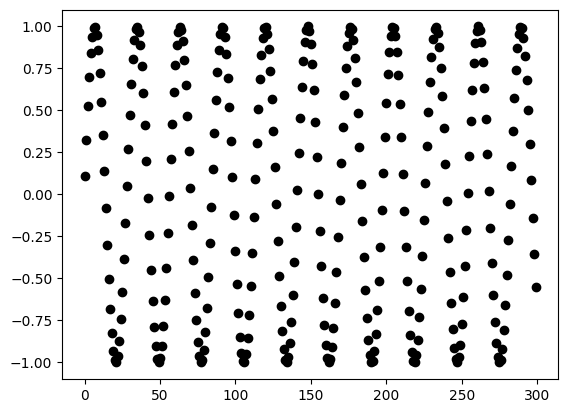

Linear interpolation


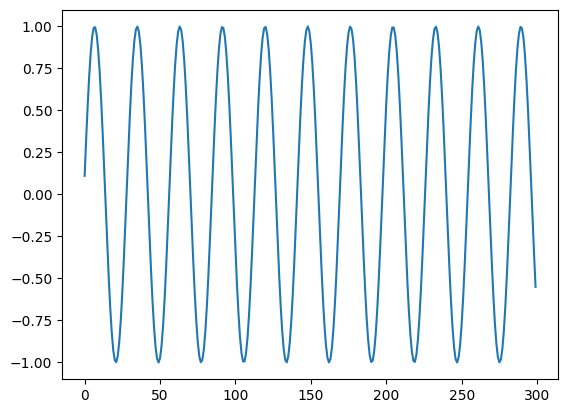

In [ ]:
# Scatter plot and linear interpolation
theta = 1 / 9  # angle in radians (can be changed as desired)
t = np.arange(0, 300, 1)  # (start, stop, step)
y = np.sin((2 * t + 1) * theta)

print("Scatter plot")
plt.plot(t, y, "o", color="black")
plt.show()

print("Linear interpolation")
plt.plot(t, y)
plt.show()

Naturally, in addition to making the probability of obtaining an element $x \in A_1$ from the measurement large, we would also like to choose $t$ to be as small as possible, because $t$ applications of the operation $G$ requires $t$ queries to the function $f$. Because we're aiming to make $\sin((2t + 1)\theta)$ close to 1 in absolute value, a natural way to do this is to choose $t$ so that

$$
(2t + 1)\theta \approx \frac{\pi}{2}.
$$

Solving for $t$ yields

$$
t \approx \frac{\pi}{4\theta} - \frac{1}{2}.
$$

Of course, $t$ must be an integer, so we won't necessarily be able to hit this value exactly — but what we can do is to take the closest integer to this value, which is

$$
t = \left\lfloor \frac{\pi}{4\theta} \right\rceil.
$$

This is the recommended number of iterations for Grover's algorithm. As we proceed with the analysis, we'll see that the closeness of this integer to the target value naturally affects the performance of the algorithm. (As an aside, if the target value $\pi/(4\theta) - 1/2$ happens to be exactly half-way between two integers, this expression of $t$ is what we get by rounding up. We could alternatively round down, which makes sense to do because it means one fewer query — but this is secondary and unimportant for the sake of the lesson.)

Recalling that the value of the angle $\theta$ is given by the formula

$$
\theta = \sin^{-1}\left( \sqrt{\frac{|A_1|}{N}} \right),
$$

we see that the recommended number of iterations $t$ depends on the number of strings in $A_1$. This presents a challenge if we don't know how many solutions we have, as we'll discuss later.

### [Unique search](#unique-search)

First, let's focus on the situation in which there's a single string $x$ such that $f(x) = 1$. Another way to say this is that we're considering an instance of the *Unique search* problem. In this case we have

$$
\theta = \sin^{-1}\left( \sqrt{\frac{1}{N}} \right),
$$

which can be conveniently approximated as

$$
\theta = \sin^{-1}\left( \sqrt{\frac{1}{N}} \right) \approx \sqrt{\frac{1}{N}}
$$

when $N$ gets large. If we substitute $\theta = 1/\sqrt{N}$ into the expression

$$
t = \left\lfloor \frac{\pi}{4\theta} \right\rceil
$$

we obtain

$$
t = \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rceil.
$$

Recalling that $t$ is not only the number of times the operation $G$ is performed, but also the number of queries to the function $f$ required by the algorithm, we see that we're on track to obtaining an algorithm that requires $O(\sqrt{N})$ queries.

Now we'll investigate how well this choice of $t$ works. The probability that the final measurement results in the unique solution can be expressed explicitly as

$$
p(N, 1) = \sin^2((2t + 1)\theta).
$$

The first argument, $N$, refers to the number of items we're searching over, and the second argument, which is 1 in this case, refers to the number of solutions. A bit later we'll use the same notation more generally, where there are multiple solutions.

The following Python code calculates the probability of success for increasing values of $n$.



In [7]:
# Probabilities of success
for n in range(1, 20):
    N = 2**n
    theta = np.arcsin(np.sqrt(1 / N))
    t = math.floor(np.pi / (4 * theta))
    p = np.sin((2 * t + 1) * theta) ** 2
    print("%d\t %12.10f" % (N, p))

2	 0.5000000000
4	 1.0000000000
8	 0.9453125000
16	 0.9613189697
32	 0.9991823155
64	 0.9965856808
128	 0.9956198657
256	 0.9999470421
512	 0.9994480262
1024	 0.9994612447
2048	 0.9999968478
4096	 0.9999453461
8192	 0.9999157752
16384	 0.9999997811
32768	 0.9999868295
65536	 0.9999882596
131072	 0.9999992587
262144	 0.9999978382
524288	 0.9999997279


Notice that these probabilities are not strictly increasing. In particular, we have an interesting anomaly when $N = 4$, where we get a solution with certainty. It can, however, be proved in general that

$$
p(N, 1) \geq 1 - \frac{1}{N}
$$

for all $N$, so the probability of success goes to 1 in the limit as $N$ becomes large, as the values above seem to suggest. This is good!

But notice, however, that even a weak bound such as $p(N, 1) \geq 1/2$ establishes the utility of Grover's algorithm. For whatever measurement outcome $x$ we obtain from running the procedure, we can always check to see if $f(x) = 1$ using a single query to $f$. And if we fail to obtain the unique string $x$ for which $f(x) = 1$ with probability at most $1/2$ by running the procedure once, then after $m$ independent runs of the procedure we will have failed to obtain this unique string $x$ with probability at most $2^{-m}$.

That is, using $O(m\sqrt{N})$ queries to $f$, we'll obtain the unique solution $x$ with probability at least $1 - 2^{-m}$. Using the better bound $p(N, 1) \geq 1 - 1/N$ reveals that the probability to find $x \in A_1$ using this method is actually at least $1 - N^{-m}$.



### [Multiple solutions](#multiple-solutions)

As the number of elements in $A_1$ varies, so too does the angle $\theta$, which can have a significant effect on the algorithm's probability of success. For the sake of brevity, let's write $s = |A_1|$ to denote the number of solutions, and as before we'll assume that $s \geq 1$.

As a motivating example, let's imagine that we have $s = 4$ solutions rather than a single solution, as we considered above. This means that

$$
\theta = \sin^{-1}\left( \sqrt{\frac{4}{N}} \right),
$$

which is approximately double the angle we had in the $|A_1| = 1$ case when $N$ is large. Suppose that we didn’t know any better, and selected the same value of $t$ as in the unique solution setting:

$$
t = \left\lfloor \frac{\pi}{4 \sin^{-1}\left( 1 / \sqrt{N} \right)} \right\rceil.
$$

The effect will be catastrophic as the following code demonstrates.


In [8]:
# Starting the loop with n=2 because we can't have 4 solutions
# when n=1.

for n in range(2, 20):
    N = 2**n
    wrong_theta = np.arcsin(np.sqrt(1 / N))
    correct_theta = np.arcsin(np.sqrt(4 / N))
    t = math.floor(np.pi / (4 * wrong_theta))
    p = np.sin((2 * t + 1) * correct_theta) ** 2
    print("%d\t %12.10f" % (N, p))

4	 1.0000000000
8	 0.5000000000
16	 0.2500000000
32	 0.0122070313
64	 0.0203807689
128	 0.0144530758
256	 0.0000705058
512	 0.0019310741
1024	 0.0023009083
2048	 0.0000077506
4096	 0.0002301502
8192	 0.0003439882
16384	 0.0000007053
32768	 0.0000533810
65536	 0.0000472907
131072	 0.0000030066
262144	 0.0000086824
524288	 0.0000010820


This time the probability of success goes to 0 as $N$ goes to infinity. This happens because we're effectively rotating twice as fast as we did when there was a unique solution, so we end up zooming past the target $|A_1\rangle$ and landing near $-|A_0\rangle$.

However, if instead we use the recommended choice of $t$, which is

$$
t = \left\lfloor \frac{\pi}{4\theta} \right\rceil
$$

for

$$
\theta = \sin^{-1}\left( \sqrt{\frac{s}{N}} \right),
$$

then the performance will be better. To be more precise, using this choice of $t$ leads to success with high probability.


In [ ]:
s = 7  # Number of solutions. This can be any positive integer.

# The loop starts with the smallest value of n that allows s solutions.
for n in range(math.ceil(math.log2(s)), math.ceil(math.log2(s)) + 20):
    N = 2**n
    theta = np.arcsin(np.sqrt(s / N))
    t = math.floor(np.pi / (4 * theta))
    p = np.sin((2 * t + 1) * theta) ** 2
    print("%d\t %12.10f" % (N, np.sin((2 * t + 1) * theta) ** 2))

Generalizing what was claimed earlier, it can be proved that

$$
p(N, s) \geq 1 - \frac{s}{N},
$$

where we're using the notation suggested earlier: $p(N, s)$ denotes the probability that Grover's algorithm run for $t$ iterations reveals a solution when there are $s$ solutions in total out of $N$ possibilities. This lower bound of $1 - s/N$ on the probability of success is slightly peculiar in that more solutions implies a worse lower bound — but under the assumption that $s$ is significantly smaller than $N$, we nevertheless conclude that the probability of success is reasonably high. As before, the mere fact that $p(N, s)$ is reasonably large implies the algorithm's usefulness.

It also happens to be the case that

$$
p(N, s) \geq \frac{s}{N}.
$$

This lower bound describes the probability that a string $x \in \Sigma^n$ selected uniformly at random is a solution — so Grover's algorithm always does at least as well as random guessing. (In fact, when $t = 0$, Grover's algorithm is random guessing.)

Now let's take a look at the number of iterations (and hence the number of queries)

$$
t = \left\lfloor \frac{\pi}{4\theta} \right\rceil,
$$

for

$$
\theta = \sin^{-1}\left( \sqrt{\frac{s}{N}} \right).
$$

For every $\alpha \in [0, 1]$, it is the case that $\sin^{-1}(\alpha) \geq \alpha$, and so

$$
\theta = \sin^{-1}\left( \sqrt{\frac{s}{N}} \right) \geq \sqrt{\frac{s}{N}}.
$$

This implies that

$$
t \leq \frac{\pi}{4\theta} \leq \frac{\pi}{4} \sqrt{\frac{N}{s}}.
$$

This translates to a savings in the number of queries as $s$ grows. In particular, the number of queries required is

$$
O\left( \sqrt{\frac{N}{s}} \right).
$$


### [Unknown number of solutions](#unknown-solutions)

If the number of solutions $s = |A_1|$ is *unknown*, then a different approach is required, for in this situation we have no knowledge of $s$ to inform our choice of $t$. There are, in fact, multiple approaches.

One simple approach is to choose

$$
t \in \left\{ 1, \dots, \left\lfloor \pi \sqrt{N} / 4 \right\rfloor \right\}
$$

*Uniformly at random.* Selecting $t$ in this way always finds a solution (assuming one exists) with probability greater than 40%, though this is not obvious and requires an analysis that will not be included here. It does make sense, however, particularly when we think about the geometric picture: rotating the state of $Q$ a random number of times like this is not unlike choosing a random unit vector in the space spanned by $|A_0\rangle$ and $|A_1\rangle$, for which it is likely that the coefficient of $|A_1\rangle$ is reasonably large. By repeating this procedure and checking the outcome in the same way as described before, the probability to find a solution can be made very close to 1.

There is a refined method that finds a solution when one exists using $O(\sqrt{N/s})$ queries, even when the number of solutions $s$ is not known, and requires $O(\sqrt{N})$ queries to determine that there are no solutions when $s = 0$. The basic idea is to choose $t$ uniformly at random from the set $\{1, \dots, T\}$ iteratively, for increasing values of $T$. In particular, we can start with $T = 1$ and increase it exponentially, always terminating the process as soon as a solution is found and capping $T$ so as not to waste queries when there isn’t a solution. The process takes advantage of the fact that fewer queries are required when more solutions exist. Some care is required, however, to balance the rate of growth of $T$ with the probability of success for each iteration. (Taking $T \leftarrow \left\lceil \frac{5}{4} T \right\rceil$ works, for instance, as an analysis reveals. Doubling $T$, however, does not — this turns out to be too fast of an increase.)



### [The trivial cases](#trivial-cases)

Throughout the analysis we’ve just gone through, we’ve assumed that the number of solutions is non-zero. Indeed, by referring to the vectors

$$
|A_0\rangle = \frac{1}{\sqrt{|A_0|}} \sum_{x \in A_0} |x\rangle \\
|A_1\rangle = \frac{1}{\sqrt{|A_1|}} \sum_{x \in A_1} |x\rangle
$$

we have implicitly assumed that $A_0$ and $A_1$ are both nonempty. Here we will briefly consider what happens when one of these sets is empty.

Before we bother with an analysis, let’s observe the obvious: if every string $x \in \Sigma^n$ is a solution, then we’ll see a solution when we measure; and when there aren’t any solutions, we won’t see one. In some sense there’s no need to go deeper than this.

We can, however, quickly verify the mathematics for these trivial cases. The situation where one of $A_0$ and $A_1$ is empty happens when $f$ is constant; $A_1$ is empty when $f(x) = 0$ for every $x \in \Sigma^n$, and $A_0$ is empty when $f(x) = 1$ for every $x \in \Sigma^n$. This means that

$$
Z_f |u\rangle = \pm |u\rangle,
$$

and therefore

$$
\begin{aligned}
G|u\rangle &= (2|u\rangle \langle u| - I) Z_f |u\rangle \\
          &= \pm (2|u\rangle \langle u| - I) |u\rangle \\
          &= \pm |u\rangle.
\end{aligned}
$$

So, irrespective of the number of iterations $t$ we perform in these cases, the measurements will always reveal a uniform random string $x \in \Sigma^n$.



## [Qiskit implementation](#qiskit-implementation)


An impl,ementation on Grover's Algorithm in Quskit can be found in this Tutorial [Grover's Algorithm](../tutorials/grovers-algorithm.ipynb)

## [Concluding remarks](#concluding-remarks)

Within the query model, Grover's algorithm is *asymptotically optimal*. What this means is that it's not possible to come up with a query algorithm for solving the **Search** problem, or even the **Unique search** problem specifically, that uses asymptotically less than $O(\sqrt{N})$ queries in the worst case. This is something that has been proved rigorously in multiple ways. Interestingly, this was known even before Grover's algorithm was discovered — Grover's algorithm matched an already-known lower bound.

Grover's algorithm is also broadly applicable, in the sense that the square-root speed-up that it offers can be obtained in a variety of different settings. For example, sometimes it's possible to use Grover's algorithm in conjunction with another algorithm to get an improvement. Grover's algorithm is also quite commonly used as a subroutine inside of other quantum algorithms to obtain speed-ups.

Finally, the technique used in Grover's algorithm, where two reflections are composed and iterated to rotate a quantum state vector, can be generalized. An example is a technique known as *amplitude amplification*, where a process similar to Grover's algorithm can be applied to another quantum algorithm to boost its success probability quadratically faster than what is possible classically. Amplitude amplification has broad applications in quantum algorithms.

So, although Grover's algorithm may not lead to a practical quantum advantage for searching any time soon, it is a fundamentally important quantum algorithm, and it is representative of a more general technique that finds many applications in quantum algorithms.
